# 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기
- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

# 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용

# 데이터 처리

In [ ]:
# 데이터 다운로드
!git clone https://github.com/e9t/nsmc.git

fatal: destination path 'nsmc' already exists and is not an empty directory.


In [ ]:
import pandas as pd

# 데이터 읽기
train_data = pd.read_csv('nsmc/ratings_train.txt', sep='\t', header=0)
test_data = pd.read_csv('nsmc/ratings_test.txt', sep='\t', header=0)

## 읽어온 데이터 탐색

In [ ]:
# 구조
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
def check_missing_values(data, name):
    # 결측 데이터의 존재 여부를 확인
    if data.isnull().any().any():
        missing_info = data.isnull().sum()
        print(f"{name}: 결측치가 있습니다. 각 열의 결측치 수는 다음과 같습니다:\n{missing_info}")
        # 결측치가 있는 행을 출력
        missing_rows = data[data.isnull().any(axis=1)]
        print(f"{name}: 결측치가 있는 행은 다음과 같습니다:\n{missing_rows}")
    else:
        print(f"{name}: 결측치가 없습니다. 데이터 크기는 {data.shape}입니다")

check_missing_values(train_data, 'train_data')
check_missing_values(test_data, 'test_data')

train_data: 결측치가 있습니다. 각 열의 결측치 수는 다음과 같습니다:
id          0
document    5
label       0
dtype: int64
train_data: 결측치가 있는 행은 다음과 같습니다:
             id document  label
25857   2172111      NaN      1
55737   6369843      NaN      1
110014  1034280      NaN      0
126782  5942978      NaN      0
140721  1034283      NaN      0
test_data: 결측치가 있습니다. 각 열의 결측치 수는 다음과 같습니다:
id          0
document    3
label       0
dtype: int64
test_data: 결측치가 있는 행은 다음과 같습니다:
            id document  label
5746    402110      NaN      1
7899   5026896      NaN      0
27097   511097      NaN      1


In [ ]:
def remove_missing_values(data, name):
    # 결측치 제거 전 데이터 크기
    original_size = data.shape
    print(f"{name}: 결측치 제거 전 데이터 크기는 {original_size}입니다.")

    # 결측치가 있는 행을 제거
    data_cleaned = data.dropna()

    # 결측치 제거 후 데이터 크기
    cleaned_size = data_cleaned.shape
    print(f"{name}: 결측치 제거 후 데이터 크기는 {cleaned_size}입니다.")

    # 제거된 행의 수
    rows_removed = original_size[0] - cleaned_size[0]
    print(f"{name}: 제거된 행의 수는 {rows_removed}개입니다.")

    return data_cleaned

# train_data에서 결측치가 있는 행을 제거하고 결과를 출력
train_data = remove_missing_values(train_data, 'train_data')

# test_data에서 결측치가 있는 행을 제거하고 결과를 출력
test_data = remove_missing_values(test_data, 'test_data')


train_data: 결측치 제거 전 데이터 크기는 (150000, 3)입니다.
train_data: 결측치 제거 후 데이터 크기는 (149995, 3)입니다.
train_data: 제거된 행의 수는 5개입니다.
test_data: 결측치 제거 전 데이터 크기는 (50000, 3)입니다.
test_data: 결측치 제거 후 데이터 크기는 (49997, 3)입니다.
test_data: 제거된 행의 수는 3개입니다.


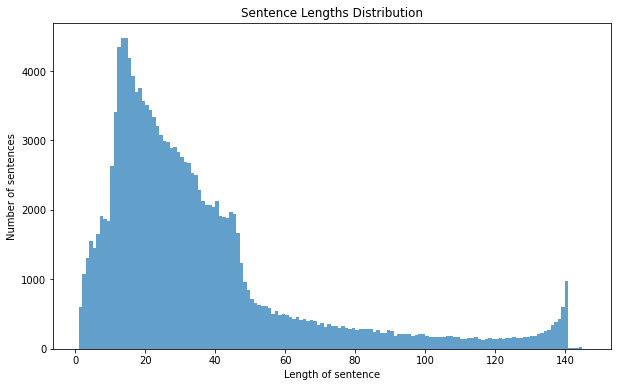

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 'document' 열을 추출하여 리스트로 변환
train_corpus = train_data['document'].tolist()

# cleaned_corpus 내의 문장들의 길이를 리스트로 계산
sentence_lengths = [len(sentence) for sentence in train_corpus]

# 문장 길이의 분포를 히스토그램으로 시각화
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=range(min(sentence_lengths), max(sentence_lengths) + 1, 1), alpha=0.7)
plt.title('Sentence Lengths Distribution')
plt.xlabel('Length of sentence')
plt.ylabel('Number of sentences')
plt.show()

In [ ]:
# 문장 길이가 1인 데이터를 별도의 데이터프레임으로 저장
def filter_single_word_sentences(dataframe):
    # 'document' 열에서 각 문장을 띄어쓰기로 나누어 단어의 수를 계산
    sentence_lengths = dataframe['document'].str.split().str.len()
    # 문장 길이가 1인 데이터만 필터링
    single_word_df = dataframe[sentence_lengths == 1]
    return single_word_df

# 메인 코드
single_word_sentences = filter_single_word_sentences(train_data)
print(single_word_sentences)

              id           document  label
2       10265843  너무재밓었다그래서보는것을추천한다      0
10       9008700   걍인피니트가짱이다.진짜짱이다♥      1
28       6091784               재밋는뎅      1
54       7207064              재미있어요      1
56       1651126                 최고      0
...          ...                ...    ...
149919   6502490                  짱      1
149960   6368431               지루하다      0
149961   7154176               짠하다~      1
149966   6735753                  1      0
149987   7669621            재미있어요^^      1

[12376 rows x 3 columns]


In [ ]:
def check_duplicates(data, name):
    # 중복 데이터의 존재 여부를 확인
    if data.duplicated().any():
        print(f"{name}: 중복 데이터가 있습니다. 데이터 크기는 {data.shape}입니다")
    else:
        print(f"{name}: 중복 데이터가 없습니다. 데이터 크기는 {data.shape}입니다")

check_duplicates(train_data, 'train_data')
check_duplicates(test_data, 'test_data')

train_data: 중복 데이터가 없습니다. 데이터 크기는 (149995, 3)입니다
test_data: 중복 데이터가 없습니다. 데이터 크기는 (49997, 3)입니다


## 노이즈 처리 (문장 정규화)

문장 정규화는 아래와 같은 순서로 진행됩니다.
- 특수문자를 한자, 일본어, 그 외 특수문자의 세 부류로 나눔(미완성형 한글('ㅋㅋㅋ' 'ㅠㅠㅠ' 등)도 포함)
- 세 부류의 특수문자들이 포함된 행들을 살펴보고 아래와 같이 진행
  - 한자 중 특수문자 성격을 갖는 글자('凸', '乃', '皿')는 그 외 특수문자로 옮김
  - 일본어, 한자가 포함된 행은 숫자가 많지 않아 모두 삭제 (약 200여개)
  - `♥^()!,.` 와 같이 주요한 부호이거나 감정이 강하게 담긴 특수문자, 그리고 'ㅋㅋㅋ', 'ㅜㅜㅜ'등 한글로 표현된 감정표현을 감안하여 한글 미완성형 자모를 제외한 모든 특수문자 삭제
  - 특수문자 삭제 후 빈 괄호`()`는 모두 삭제

In [ ]:
import re

def find_special_characters(dataframe):
    # 한글, 영문, 숫자, 기본 문장부호, 공백을 제외한 패턴 정의
    pattern = re.compile('[^가-힣a-zA-Z0-9.,?! ]')

    # 특수문자를 저장할 집합
    special_characters = set()

    # 데이터프레임의 'document' 열을 순회하며 특수문자를 찾음
    for document in dataframe['document']:
        # 문자열 타입이 아닌 경우 문자열로 변환
        document = str(document)
        # 정규 표현식을 사용하여 특수문자 찾기
        matches = pattern.findall(document)
        # 찾은 특수문자를 집합에 추가
        special_characters.update(matches)

    # 찾은 특수문자 출력
    print(f"특수문자 목록: {special_characters}")
    return special_characters

# train_data의 'document' 열에서 특수문자 찾기
special_characters = find_special_characters(train_data)

특수문자 목록: {'望', 'ス', '情', '結', '※', 'ㅤ', 'ト', '━', '紐', '綠', '糞', 'マ', '甲', '＾', '火', '味', '低', 'り', 'ㅠ', '§', '♫', 'ㅗ', '《', 'シ', '美', '>', '☆', '紅', '驛', 'き', ']', 'は', '感', '女', '◁', 'ⅲ', 'ㅖ', '=', '<', '憎', '一', '○', 'す', '部', 'ら', '₂', '史', '¿', '求', 'イ', '傑', '期', '˚', '慄', 'ろ', '’', 'エ', '¨', '也', '韓', '↗', '英', 'る', 'だ', '≥', '集', '→', '♧', '手', '面', 'タ', 'の', 'と', '流', '笑', 'ㅁ', '”', 'ㄸ', '⑦', 'カ', 'バ', 'う', '論', 'ⁿ', 'グ', 'ㅕ', 'ㅎ', '慶', '霆', '峰', 'ⓒ', '本', '助', '¡', '待', 'ㅉ', '祖', 'づ', '【', 'デ', '『', 'が', '大', 'ㅔ', 'ㅅ', '自', '喜', 'ひ', 'ㆀ', '式', '都', '孝', 'つ', '車', '生', '¤', '申', '_', '天', 'ㅜ', 'っ', '(', '彼', '舒', 'ョ', '蜀', '蒼', '「', '後', 'た', '侖', '‥', '■', '‘', '江', '♬', 'ㄴ', '´', 'ㅘ', '￣', '用', 'ㄻ', '\xad', '苦', '°', '謝', 'ㄵ', '/', 'い', 'ㅐ', '僞', '觸', '●', 'ま', 'パ', '非', 'π', '王', '·', '葉', 'ね', '倭', 'ㅡ', '死', '…', '末', '↓', '」', '紙', '`', '∇', '故', '□', '禮', '會', '言', '惡', '律', 'ㅂ', '"', '』', 'ダ', '反', '道', '盧', '彩', '♤', '？', '亞', '岡', 'ㅍ', '型', '中', '～', '眞', '愛', 'れ', 'ッ

In [ ]:
# 분류할 리스트 초기화
chinese_characters = []  # 한자
japanese_characters = []  # 일본어
other_characters = []  # 기타 특수문자

# 각 문자에 대한 유니코드 범위를 확인하여 분류
for char in special_characters:
    # 한자 범위 (유니코드 4E00-9FFF)
    if '\u4e00' <= char <= '\u9fff':
        chinese_characters.append(char)
    # 일본어 가타카나 범위 (유니코드 30A0-30FF) 및 히라가나 범위 (유니코드 3040-309F)
    elif '\u30a0' <= char <= '\u30ff' or '\u3040' <= char <= '\u309f':
        japanese_characters.append(char)
    # 기타 특수문자 (그 외)
    else:
        other_characters.append(char)

# 결과 출력
print(f"한자 리스트: {chinese_characters}")
print(f"일본어 리스트: {japanese_characters}")
print(f"기타 특수문자 리스트: {other_characters}")


한자 리스트: ['望', '情', '結', '糞', '甲', '火', '味', '低', '美', '紅', '驛', '感', '女', '憎', '一', '部', '史', '求', '傑', '期', '也', '韓', '英', '集', '手', '面', '流', '笑', '論', '慶', '霆', '峰', '本', '助', '待', '祖', '大', '自', '喜', '式', '都', '孝', '車', '生', '申', '天', '彼', '舒', '蜀', '蒼', '後', '侖', '江', '用', '苦', '謝', '僞', '觸', '非', '王', '葉', '倭', '死', '末', '紙', '故', '會', '言', '惡', '反', '道', '彩', '亞', '岡', '型', '中', '眞', '愛', '緣', '野', '前', '香', '法', '日', '高', '力', '淇', '男', '吐', '忍', '山', '臭', '皿', '凸', '外', '看', '記', '的', '藝', '新', '頑', '者', '禪', '刻', '檢', '品', '三', '柱', '戰', '友', '演', '色', '林', '最', '錢', '電', '離', '敵', '要', '急', '下', '家', '性', '失', '鈴', '亡', '異', '氣', '直', '見', '間', '濡', '張', '讐', '善', '人', '作', '曲', '漁', '里', '好', '無', '害', '眠', '終', '有', '出', '益', '念', '鋒', '師', '腸', '旋', '塵', '神', '候', '田', '名', '歌', '古', '復', '完', '木', '先', '佑', '秀', '典', '様', '幸', '月', '希', '定', '難', '北', '年', '湖', '立', '信', '乃', '白', '峽', '派', '小', '画', '蟲', '映', '上', '必']
일본어 리스트: ['ス', 'ト', 'マ', 'り', 'シ', 'き', 'は', 'す', '

In [ ]:
# 한글 자모 범위
# 초성: ㄱ(0x3131)부터 ㅎ(0x314E)
# 중성: ㅏ(0x314F)부터 ㅣ(0x3163)
# 종성: ㄱ(0x11A8)부터 ㅎ(0x11C2), 단 종성은 완성형 한글 코드에 포함되므로 별도로 체크하지 않음

# 한글 문자 목록 초기화
korean_characters = []

# 기타 특수문자 리스트에서 한글 자모 문자를 찾아 한글 목록으로 이동
for char in other_characters[:]:  # 리스트를 복사하여 반복
    if '\u3131' <= char <= '\u314E' or '\u314F' <= char <= '\u3163' or '가' <= char <= '힣':
        korean_characters.append(char)
        other_characters.remove(char)

# 결과 출력
print(f"한자 리스트: {chinese_characters}")
print(f"일본어 리스트: {japanese_characters}")
print(f"한글 문자 리스트: {korean_characters}")
print(f"기타 특수문자 리스트: {other_characters}")

한자 리스트: ['望', '情', '結', '糞', '甲', '火', '味', '低', '美', '紅', '驛', '感', '女', '憎', '一', '部', '史', '求', '傑', '期', '也', '韓', '英', '集', '手', '面', '流', '笑', '論', '慶', '霆', '峰', '本', '助', '待', '祖', '大', '自', '喜', '式', '都', '孝', '車', '生', '申', '天', '彼', '舒', '蜀', '蒼', '後', '侖', '江', '用', '苦', '謝', '僞', '觸', '非', '王', '葉', '倭', '死', '末', '紙', '故', '會', '言', '惡', '反', '道', '彩', '亞', '岡', '型', '中', '眞', '愛', '緣', '野', '前', '香', '法', '日', '高', '力', '淇', '男', '吐', '忍', '山', '臭', '皿', '凸', '外', '看', '記', '的', '藝', '新', '頑', '者', '禪', '刻', '檢', '品', '三', '柱', '戰', '友', '演', '色', '林', '最', '錢', '電', '離', '敵', '要', '急', '下', '家', '性', '失', '鈴', '亡', '異', '氣', '直', '見', '間', '濡', '張', '讐', '善', '人', '作', '曲', '漁', '里', '好', '無', '害', '眠', '終', '有', '出', '益', '念', '鋒', '師', '腸', '旋', '塵', '神', '候', '田', '名', '歌', '古', '復', '完', '木', '先', '佑', '秀', '典', '様', '幸', '月', '希', '定', '難', '北', '年', '湖', '立', '信', '乃', '白', '峽', '派', '小', '画', '蟲', '映', '上', '必']
일본어 리스트: ['ス', 'ト', 'マ', 'り', 'シ', 'き', 'は', 'す', '

In [ ]:
# 특수문자 내 이동할 한자들의 집합
move_to_chinese = {'慄', '禮', '綠', '盧', '律', '紐', '老', '不'}

# 기타 특수문자 리스트에서 해당 문자들을 한자 리스트로 이동
for char in move_to_chinese:
    if char in other_characters:
        chinese_characters.append(char)
        other_characters.remove(char)

print(f"한자 리스트: {chinese_characters}")
print(f"기타 특수문자 리스트: {other_characters}")

한자 리스트: ['望', '情', '結', '糞', '甲', '火', '味', '低', '美', '紅', '驛', '感', '女', '憎', '一', '部', '史', '求', '傑', '期', '也', '韓', '英', '集', '手', '面', '流', '笑', '論', '慶', '霆', '峰', '本', '助', '待', '祖', '大', '自', '喜', '式', '都', '孝', '車', '生', '申', '天', '彼', '舒', '蜀', '蒼', '後', '侖', '江', '用', '苦', '謝', '僞', '觸', '非', '王', '葉', '倭', '死', '末', '紙', '故', '會', '言', '惡', '反', '道', '彩', '亞', '岡', '型', '中', '眞', '愛', '緣', '野', '前', '香', '法', '日', '高', '力', '淇', '男', '吐', '忍', '山', '臭', '皿', '凸', '外', '看', '記', '的', '藝', '新', '頑', '者', '禪', '刻', '檢', '品', '三', '柱', '戰', '友', '演', '色', '林', '最', '錢', '電', '離', '敵', '要', '急', '下', '家', '性', '失', '鈴', '亡', '異', '氣', '直', '見', '間', '濡', '張', '讐', '善', '人', '作', '曲', '漁', '里', '好', '無', '害', '眠', '終', '有', '出', '益', '念', '鋒', '師', '腸', '旋', '塵', '神', '候', '田', '名', '歌', '古', '復', '完', '木', '先', '佑', '秀', '典', '様', '幸', '月', '希', '定', '難', '北', '年', '湖', '立', '信', '乃', '白', '峽', '派', '小', '画', '蟲', '映', '上', '必', '老', '紐', '慄', '綠', '禮', '律', '不', '盧']
기타 특수문자 리스트

In [ ]:
def find_rows_with_special_characters(dataframe, special_chars):
    # 원래 설정 저장
    original_max_colwidth = pd.get_option('display.max_colwidth')
    original_max_rows = pd.get_option('display.max_rows')

    # 출력할 최대 열 너비와 행 수를 None으로 설정하여 모든 내용을 출력
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_rows', None)

    try:
        # 특수문자를 포함하는 행을 찾기 위한 불리언 시리즈 생성
        mask = dataframe['document'].apply(lambda x: any(char in str(x) for char in special_chars))

        # 특수문자를 포함하는 행을 필터링
        rows_with_special_chars = dataframe[mask]

        # 결과 출력
        print(rows_with_special_chars)
    finally:
        # 출력 설정을 원래대로 복구
        pd.set_option('display.max_colwidth', original_max_colwidth)
        pd.set_option('display.max_rows', original_max_rows)

In [ ]:
# 'document' 열에서 한자를 포함하는 행을 찾아 출력
find_rows_with_special_characters(train_data, chinese_characters)

In [ ]:
# 한자 내 이동할 글자들의 집합 (특수문자 성격으로 사용된 글자들)
move_to_others = {'凸', '乃', '皿'}

# 기타 특수문자 리스트에서 해당 문자들을 한자 리스트로 이동
for char in move_to_others:
    if char in chinese_characters:
        other_characters.append(char)
        chinese_characters.remove(char)

# 결과 출력
print(f"한자 리스트: {chinese_characters}")
print(f"기타 특수문자 리스트: {other_characters}")

한자 리스트: ['望', '情', '結', '糞', '甲', '火', '味', '低', '美', '紅', '驛', '感', '女', '憎', '一', '部', '史', '求', '傑', '期', '也', '韓', '英', '集', '手', '面', '流', '笑', '論', '慶', '霆', '峰', '本', '助', '待', '祖', '大', '自', '喜', '式', '都', '孝', '車', '生', '申', '天', '彼', '舒', '蜀', '蒼', '後', '侖', '江', '用', '苦', '謝', '僞', '觸', '非', '王', '葉', '倭', '死', '末', '紙', '故', '會', '言', '惡', '反', '道', '彩', '亞', '岡', '型', '中', '眞', '愛', '緣', '野', '前', '香', '法', '日', '高', '力', '淇', '男', '吐', '忍', '山', '臭', '外', '看', '記', '的', '藝', '新', '頑', '者', '禪', '刻', '檢', '品', '三', '柱', '戰', '友', '演', '色', '林', '最', '錢', '電', '離', '敵', '要', '急', '下', '家', '性', '失', '鈴', '亡', '異', '氣', '直', '見', '間', '濡', '張', '讐', '善', '人', '作', '曲', '漁', '里', '好', '無', '害', '眠', '終', '有', '出', '益', '念', '鋒', '師', '腸', '旋', '塵', '神', '候', '田', '名', '歌', '古', '復', '完', '木', '先', '佑', '秀', '典', '様', '幸', '月', '希', '定', '難', '北', '年', '湖', '立', '信', '白', '峽', '派', '小', '画', '蟲', '映', '上', '必', '老', '紐', '慄', '綠', '禮', '律', '不', '盧']
기타 특수문자 리스트: ['※', 'ㅤ', '━

In [ ]:
# 'document' 열에서 일본어를 포함하는 행을 찾아 출력
find_rows_with_special_characters(train_data, japanese_characters)

In [ ]:
def remove_rows_with_chars(dataframe, chars):
    # 특정 문자를 포함하지 않는 행을 찾기 위한 불리언 시리즈 생성
    mask = dataframe['document'].apply(lambda x: not any(char in str(x) for char in chars))

    # 특정 문자를 포함하지 않는 행만 필터링
    dataframe_without_chars = dataframe[mask]

    return dataframe_without_chars

# 일본어와 한자가 포함된 데이터 숫자가 많지 않아, 'document' 열에서 일본어 문자와 한자를 포함하는 행을 삭제
#  일본어 문자와 한자가 포함된 행을 삭제하기 전의 데이터 크기
original_size = train_data.shape
train_data = remove_rows_with_chars(train_data, japanese_characters)
train_data = remove_rows_with_chars(train_data, chinese_characters)
cleaned_size = train_data.shape

# 결과 출력
print(train_data)

# 일본어 문자를 포함하는 행을 삭제한 후의 데이터 크기
print(f"삭제 전 데이터 크기: {original_size}")
print(f"삭제 후 데이터 크기: {cleaned_size}")


              id                                           document  label
0        9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1        3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2       10265843                                  너무재밓었다그래서보는것을추천한다      0
3        9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4        6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
...          ...                                                ...    ...
149995   6222902                                인간이 문제지.. 소는 뭔죄인가..      0
149996   8549745                                      평점이 너무 낮아서...      1
149997   9311800                    이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?      0
149998   2376369                        청춘 영화의 최고봉.방황과 우울했던 날들의 자화상      1
149999   9619869                           한국 영화 최초로 수간하는 내용이 담긴 영화      0

[149792 rows x 3 columns]
삭제 전 데이터 크기: (149995, 3)
삭제 후 데이터 크기: (149792, 3)


In [ ]:
# 한자와 일본어가 포함된 행 삭제 확인
find_rows_with_special_characters(train_data, japanese_characters)
find_rows_with_special_characters(train_data, chinese_characters)

Empty DataFrame
Columns: [id, document, label]
Index: []
Empty DataFrame
Columns: [id, document, label]
Index: []


In [ ]:
# 기타 특수문자가 포함된 행 확인
find_rows_with_special_characters(train_data, other_characters)

In [ ]:
# 데이터프레임의 'document' 열에 정규화를 적용하는 함수
def normalize_text(text):
    # 알파벳 대문자는 소문자로 변경
    text = str(text).lower()
    # 한글, 공백, 숫자, 알파벳, 선택한 특수문자를 제외하고 모두 제거
    return re.sub("[^가-힣a-z0-9♥^()!,. ]", "", str(text))

# 문장 평균 길이를 계산하는 함수
def calculate_average_length(df, column_name):
    average_length = df[column_name].apply(lambda x: len(str(x).split())).mean()
    return average_length

# 원본 데이터프레임 복사본을 만들어서 정규화 전 데이터를 보존
original_data = train_data.copy()

# 'document' 열에 정규화 적용
train_data['document'] = train_data['document'].apply(normalize_text)

In [ ]:
# 삭제하지 않은 특수문자 포함된 행 확인
find_rows_with_special_characters(train_data, other_characters)

In [ ]:
def empty_parentheses_rows(dataframe):
    # 괄호가 있지만 내용이 없는 패턴 정의 (공백 포함)
    pattern = re.compile(r'\(\s*\)')

    # 괄호 사이에 내용이 없는 행을 찾기 위한 불리언 시리즈 생성
    mask = dataframe['document'].apply(lambda x: bool(pattern.search(str(x))))

    # 해당하는 행 출력
    print("괄호 사이에 내용이 없는 행:")
    print(dataframe[mask])

empty_parentheses_rows(train_data)

괄호 사이에 내용이 없는 행:
              id                                           document  label
2121     8064427  저 이 거 안 봤는 데 왠지 재밌을 겄 같아요 (잠시만요, 호감 꾹! 하고 가실께요...      1
2433     8071959  캐스팅도 거참 최악이고 배우들 얼굴도 진짜 억울하다 억울해연기() 진짜 발연기도 아...      0
2717     9435611  결정적인 부분은 우연에 기댄다. 허술하고 현실성 없는 추리도 문제. 심리학자가 일은...      0
2904     8612348  어렸을 때는 지능이 뒤떨어져 이 영화의 전체적인 흐름과 스토리를, 심지어 그 때문에...      1
2960      118429                                           머나먼 사랑()      0
...          ...                                                ...    ...
146886  10012799  페이크 다큐멘타리 영화()블레어 윗치가 야마무라 사다꼬를 만났을때...쯤 되시겠다....      0
147116   8681007                                적당히 보고싶은 장면만() 보자..      0
148223   9156916  나 이렇게 연기 못하는 배우()들 첨보겠네...스토리는 둘째치고 포커스도 제때 못잡...      0
148594   8762145                        대한민국 최상류층()을 묘사하는 싸구려틱한 솜씨!      0
148729   7943200  목표()물을 봐도 너무 느려터진 좀비들 덕분에...여유롭게 챙길거 다 챙기고 도망갈...      0

[190 rows x 3 columns]


In [ ]:
def remove_empty_parentheses(dataframe):
    # 괄호가 있지만 내용이 없는 패턴 정의 (공백 포함)
    pattern = re.compile(r'\(\s*\)')

    # 괄호 사이에 내용이 없는 부분을 삭제하는 함수
    def remove_pattern(text):
        # 정규 표현식을 사용하여 해당 패턴을 공백으로 대체
        return pattern.sub('', text)

    # 'document' 열의 모든 행에 대해 위 함수 적용
    dataframe_removed = dataframe
    dataframe_removed['document'] = dataframe['document'].apply(remove_pattern)

    return dataframe_removed

# 괄호 사이에 내용이 없는 부분을 삭제
train_data = remove_empty_parentheses(train_data)

# 결과 출력
empty_parentheses_rows(train_data)

괄호 사이에 내용이 없는 행:
Empty DataFrame
Columns: [id, document, label]
Index: []


In [ ]:
# 문장 길이 변화
# 정규화 적용 전의 문장 평균 길이
original_average_length = calculate_average_length(original_data, 'document')


# 정규화 적용 후의 문장 평균 길이
normalized_average_length = calculate_average_length(train_data, 'document')
print(f"정규화 전 문장 평균 길이: {original_average_length}")
print(f"정규화 후 문장 평균 길이: {normalized_average_length}")

정규화 전 문장 평균 길이: 7.582955030976287
정규화 후 문장 평균 길이: 7.491775261696219


# 데이터로부터 단어사전 구축: 토크나이징 & 벡터화

## MeCab 토크나이징

In [ ]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data_mecab(train_data, test_data, num_words=10000):
    # 데이터 중복 제거 및 NaN 결측치 제거
    train_data = train_data.drop_duplicates(subset=['document']).dropna(how='any')
    test_data = test_data.drop_duplicates(subset=['document']).dropna(how='any')

    # 한국어 토크나이저로 토큰화 및 불용어 제거
    def tokenize_and_remove_stopwords(data):
        return [[word for word in tokenizer.morphs(sentence) if word not in stopwords] for sentence in data['document']]

    X_train, X_test = map(tokenize_and_remove_stopwords, [train_data, test_data])

    # 사전 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter.most_common(num_words-4)]
    word_to_index = {word: index for index, word in enumerate(vocab)}

    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index.get(word, word_to_index['<UNK>']) for word in wordlist]

    X_train, X_test = map(lambda x: list(map(wordlist_to_indexlist, x)), [X_train, X_test])
    y_train, y_test = np.array(train_data['label']), np.array(test_data['label'])

    return X_train, y_train, X_test, y_test, word_to_index


# 데이터 로드 및 인덱스-단어 사전 생성
X_train_mecab, y_train_mecab, X_test_mecab, y_test_mecab, word_to_index = load_data_mecab(train_data, test_data)
index_to_word = {index: word for word, index in word_to_index.items()}

In [ ]:
# 문장 인코딩 및 디코딩
def encode_sentences(sentences, word_to_index):
    return [[word_to_index.get('<BOS>')] + [word_to_index.get(word, word_to_index.get('<UNK>')) for word in sentence.split()] for sentence in sentences]

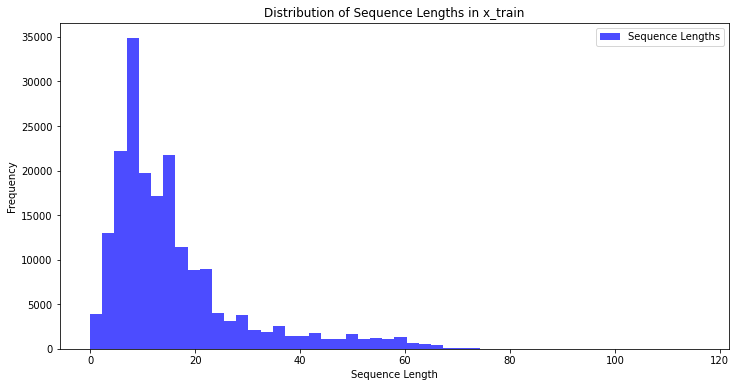

In [ ]:
import matplotlib.pyplot as plt

# X_train에 포함된 각 시퀀스의 길이를 계산
total_data_text = list(X_train_mecab) + list(X_test_mecab) # 텍스트데이터 전체 문장길이 리스트
num_tokens =  np.array([len(tokens) for tokens in total_data_text]) # 배열로 변환하여 토큰 길이 계산

# 히스토그램으로 시퀀스 길이 분포를 표시
plt.figure(figsize=(12, 6))
plt.hist(num_tokens, bins=50, alpha=0.7, color='blue', label='Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths in x_train')
plt.legend()
plt.show()

In [ ]:
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.663791551584914
문장길이 최대 :  116
문장길이 표준편차 :  12.684513197364044
pad_sequences maxlen :  53
전체 문장의 0.9712282759081815%가 maxlen 설정값 이내에 포함됩니다. 


In [ ]:
vocab_size = len(word_to_index)    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수

In [ ]:
import tensorflow as tf

X_train_mecab = tf.keras.preprocessing.sequence.pad_sequences(X_train_mecab, value=word_to_index['<PAD>'], padding='post', maxlen=maxlen)
X_test_mecab = tf.keras.preprocessing.sequence.pad_sequences(X_test_mecab, value=word_to_index['<PAD>'], padding='post', maxlen=maxlen)

In [ ]:
# validation set 분리
x_val_mecab, y_val_mecab = X_train_mecab[:50000], y_train_mecab[:50000]
partial_x_train_mecab, partial_y_train_mecab = X_train_mecab[50000:], y_train_mecab[50000:]

In [ ]:
def build_rnn_model(vocab_size, word_vector_dim, sequence_length):
    input_layer = tf.keras.Input(shape=(sequence_length,))
    embedding_layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=sequence_length)(input_layer)
    lstm_layer = tf.keras.layers.LSTM(4)(embedding_layer)
    dense_layer = tf.keras.layers.Dense(8, activation='relu')(lstm_layer)
    dropout_layer = tf.keras.layers.Dropout(0.7)(dense_layer)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
# 모델 컴파일 및 학습

model_mecab = build_rnn_model(vocab_size=10000, word_vector_dim=16, sequence_length=None)
model_mecab.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_mecab.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 336       
_________________________________________________________________
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,385
Trainable params: 160,385
Non-trainable params: 0
_______________________________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 학습 파라미터 설정
epochs = 20
batch_size = 512
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Mecab 모델을 위한 체크포인트 설정
checkpoint_path_mecab = 'best_model_mecab.h5'
model_checkpoint_mecab = ModelCheckpoint(checkpoint_path_mecab,
                                         monitor='val_loss',
                                         verbose=1,
                                         save_best_only=True)
history_mecab = model_mecab.fit(partial_x_train_mecab, partial_y_train_mecab,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_data=(x_val_mecab, y_val_mecab),
                                verbose=1,
                                callbacks=[early_stopping, model_checkpoint_mecab])

Epoch 1/20
187/187 [==============================] - 5s 9ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.5015

Epoch 00001: val_loss improved from inf to 0.69307, saving model to best_model_mecab.h5
Epoch 2/20
187/187 [==============================] - 1s 7ms/step - loss: 0.6929 - accuracy: 0.5029 - val_loss: 0.6926 - val_accuracy: 0.4991

Epoch 00002: val_loss improved from 0.69307 to 0.69257, saving model to best_model_mecab.h5
Epoch 3/20
187/187 [==============================] - 1s 7ms/step - loss: 0.6403 - accuracy: 0.5966 - val_loss: 0.5031 - val_accuracy: 0.8073

Epoch 00003: val_loss improved from 0.69257 to 0.50312, saving model to best_model_mecab.h5
Epoch 4/20
187/187 [==============================] - 1s 7ms/step - loss: 0.5250 - accuracy: 0.7548 - val_loss: 0.4281 - val_accuracy: 0.8343

Epoch 00004: val_loss improved from 0.50312 to 0.42813, saving model to best_model_mecab.h5
Epoch 5/20
187/187 [==============================] - 1s 7ms/ste

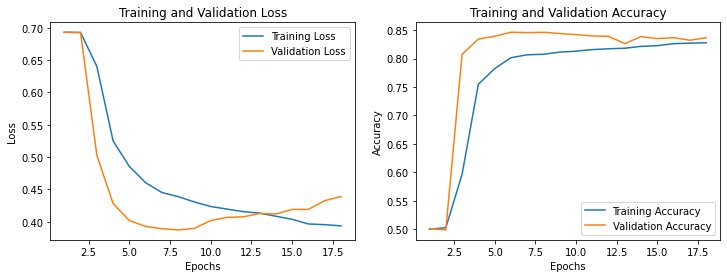

In [ ]:
import matplotlib.pyplot as plt

# 훈련 과정에서의 loss 값
train_loss = history_mecab.history['loss']
# 검증 데이터에 대한 loss 값
val_loss = history_mecab.history['val_loss']

# 훈련 과정에서의 accuracy 값
train_accuracy = history_mecab.history['accuracy']
# 검증 데이터에 대한 accuracy 값
val_accuracy = history_mecab.history['val_accuracy']

# Epochs의 범위를 설정합니다.
epochs_range = range(1, len(train_loss) + 1)

# Loss 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# 그래프를 표시합니다.
plt.show()


In [ ]:
# Mecab 모델 로드 및 평가
model_mecab.load_weights(checkpoint_path_mecab)
test_loss_mecab, test_acc_mecab = model_mecab.evaluate(X_test_mecab, y_test_mecab, verbose=1)
print(f'Test Accuracy with Mecab Tokenizer: {test_acc_mecab}')

1537/1537 [==============================] - 4s 3ms/step - loss: 0.3953 - accuracy: 0.8396
Test Accuracy with Mecab Tokenizer: 0.8395955562591553


## SentencePiece

In [ ]:
import tensorflow as tf
import numpy as np
import sentencepiece as spm

# SentencePiece 모델을 로드하는 함수
def load_sp_model(sp_model_path):
    sp = spm.SentencePieceProcessor()
    sp.Load(sp_model_path)
    return sp

# 데이터셋에서 토큰화 및 벡터화를 수행하는 함수
def tokenize_and_vectorize(dataframe, sp):
    dataframe['document'] = dataframe['document'].astype(str)  # 'document' 열을 문자열로 변환
    labels = dataframe['label'].values  # 레이블 추출
    features = [sp.EncodeAsIds(sentence) for sentence in dataframe['document']]  # 문장을 인코딩하여 벡터화
    return features, labels

# load_data 함수 수정
def load_data_sp(train_data, test_data, sp_model_path, maxlen):
    # 데이터 중복 제거 및 NaN 결측치 제거
    train_data = train_data.drop_duplicates(subset=['document']).dropna(how='any')
    test_data = test_data.drop_duplicates(subset=['document']).dropna(how='any')

    # SentencePiece 모델 로드
    sp = load_sp_model(sp_model_path)

    # 토큰화 및 벡터화
    X_train, y_train = tokenize_and_vectorize(train_data, sp)
    X_test, y_test = tokenize_and_vectorize(test_data, sp)

    # 데이터 패딩
    X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=maxlen)

    return X_train, y_train, X_test, y_test, sp, maxlen

In [ ]:
# SentencePiece 토크나이저 모델 생성
from io import StringIO

vocab_size = 8000

# StringIO를 사용하여 데이터프레임의 'document' 컬럼을 임시 파일처럼 사용
with StringIO() as f:
    # 각 문장을 새로운 줄에 쓰기
    for line in train_data['document']:
        f.write(line + '\n')
    f.seek(0)  # 파일의 시작으로 커서 이동

    # SentencePiece 모델 훈련
    spm.SentencePieceTrainer.Train(
        '--input={} --model_prefix=korean_spm --vocab_size={} --model_type=bpe'.format(f.name, vocab_size)
    )

# 생성된 모델과 보캡 파일을 확인
!ls -l korean_spm*

In [ ]:
# 토크나이저 테스트
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

In [ ]:
# 데이터 로드 (sp_model_path는 SentencePiece 모델의 파일 경로를 입력)
sp_model_path = 'korean_spm.model'
X_train_sp, y_train_sp, X_test_sp, y_test_sp, sp, maxlen = load_data_sp(train_data, test_data, sp_model_path, maxlen)

# validation set 분리
x_val_sp, y_val_sp = X_train_sp[:50000], y_train_sp[:50000]
partial_x_train_sp, partial_y_train_sp = X_train_sp[50000:], y_train_sp[50000:]

In [ ]:
maxlen = 53
model_sp = build_rnn_model(vocab_size=len(sp), word_vector_dim=16, sequence_length=maxlen)
model_sp.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 53)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 53, 16)            128000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 128,385
Trainable params: 128,385
Non-trainable params: 0
_____________________________________________________

In [ ]:
# 모델 컴파일
model_sp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 학습 파라미터
epochs = 20
batch_size = 512
# 조기 종료 콜백 정의
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# SentencePiece 모델을 위한 체크포인트 설정
checkpoint_path_sp = 'best_model_sp.h5'
model_checkpoint_sp = ModelCheckpoint(checkpoint_path_sp,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_best_only=True)

# SentencePiece 모델 학습
history_sp = model_sp.fit(partial_x_train_sp,
                          partial_y_train_sp,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(x_val_sp, y_val_sp),
                          verbose=1,
                          callbacks=[early_stopping, model_checkpoint_sp])

Epoch 1/20
187/187 [==============================] - 3s 10ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.5027

Epoch 00001: val_loss improved from inf to 0.69311, saving model to best_model_sp.h5
Epoch 2/20
187/187 [==============================] - 1s 6ms/step - loss: 0.6929 - accuracy: 0.5042 - val_loss: 0.6920 - val_accuracy: 0.5119

Epoch 00002: val_loss improved from 0.69311 to 0.69200, saving model to best_model_sp.h5
Epoch 3/20
187/187 [==============================] - 1s 7ms/step - loss: 0.6123 - accuracy: 0.6645 - val_loss: 0.4989 - val_accuracy: 0.8122

Epoch 00003: val_loss improved from 0.69200 to 0.49894, saving model to best_model_sp.h5
Epoch 4/20
187/187 [==============================] - 1s 7ms/step - loss: 0.5350 - accuracy: 0.7208 - val_loss: 0.4402 - val_accuracy: 0.8347

Epoch 00004: val_loss improved from 0.49894 to 0.44018, saving model to best_model_sp.h5
Epoch 5/20
187/187 [==============================] - 1s 7ms/step - loss: 0

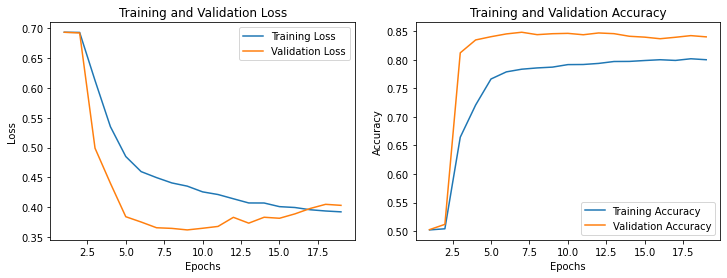

In [ ]:
import matplotlib.pyplot as plt

# 훈련 과정에서의 loss 값
train_loss = history_sp.history['loss']
# 검증 데이터에 대한 loss 값
val_loss = history_sp.history['val_loss']

# 훈련 과정에서의 accuracy 값
train_accuracy = history_sp.history['accuracy']
# 검증 데이터에 대한 accuracy 값
val_accuracy = history_sp.history['val_accuracy']

# Epochs의 범위를 설정합니다.
epochs_range = range(1, len(train_loss) + 1)

# Loss 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# 그래프를 표시합니다.
plt.show()


In [ ]:
# SentencePiece 모델 로드 및 평가
model_sp.load_weights(checkpoint_path_sp)
test_loss_sp, test_acc_sp = model_sp.evaluate(X_test_sp, y_test_sp, verbose=1)
print(f'Test Accuracy with SentencePiece Tokenizer: {test_acc_sp}')

1537/1537 [==============================] - 4s 3ms/step - loss: 0.3732 - accuracy: 0.8370
Test Accuracy with SentencePiece Tokenizer: 0.8369510173797607


## 결과 비교

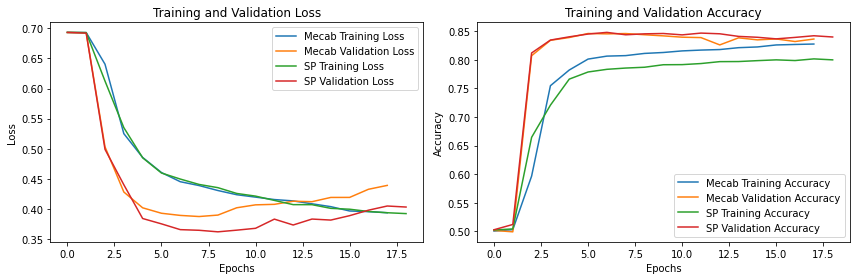

In [ ]:
import matplotlib.pyplot as plt

# Loss 그래프
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_mecab.history['loss'], label='Mecab Training Loss')
plt.plot(history_mecab.history['val_loss'], label='Mecab Validation Loss')
plt.plot(history_sp.history['loss'], label='SP Training Loss')
plt.plot(history_sp.history['val_loss'], label='SP Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history_mecab.history['accuracy'], label='Mecab Training Accuracy')
plt.plot(history_mecab.history['val_accuracy'], label='Mecab Validation Accuracy')
plt.plot(history_sp.history['accuracy'], label='SP Training Accuracy')
plt.plot(history_sp.history['val_accuracy'], label='SP Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 테스트 정확도 출력
print(f'Test Accuracy with Mecab Tokenizer: {test_acc_mecab}')
print(f'Test Accuracy with SentencePiece Tokenizer: {test_acc_sp}')

# 모델별 파라미터 수 비교
mecab_params = model_mecab.count_params()
sp_params = model_sp.count_params()
print(f'Number of parameters in model with Mecab Tokenizer: {mecab_params}')
print(f'Number of parameters in model with SentencePiece Tokenizer: {sp_params}')

Test Accuracy with Mecab Tokenizer: 0.8395955562591553
Test Accuracy with SentencePiece Tokenizer: 0.8369510173797607
Number of parameters in model with Mecab Tokenizer: 160385
Number of parameters in model with SentencePiece Tokenizer: 128385
